In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F  
import urllib.request
import os
import numpy as np
import tarfile
import shutil
import glob
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [2]:
from tqdm import tqdm

if torch.cuda.is_available():
  device=torch.device('cuda:0')
  print('Cuda')
else:
  device=torch.device('cpu')
  print('cpu')

Cuda


In [15]:
os.getcwd() # 현재 파일 디렉토리
dirname, basename  = os.path.split(os.path.dirname(os.getcwd()))
print(dirname, basename)

# model weights directory
# os.makedirs(name = dirname + '/weights', exist_ok = False)

# weights dirname
w_link = dirname + '/weights'
# train mode 
mode = 'both85'
# weights name
w_name = 'example'
epoch = 5

/home/ujkim/AI/rsh train_5


In [3]:
import torch
import random
import torch.backends.cudnn as cudnn

#파이토치의 랜덤시드 고정
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0) # gpu 1개 이상일 때 

# 넘파이 랜덤시드 고정
np.random.seed(0)

#CuDNN 랜덤시드 고정
cudnn.benchmark = False
cudnn.deterministic = True # 연산 처리 속도가 줄어들어서 연구 후반기에 사용하자

# 파이썬 랜덤시드 고정
random.seed(0)
os.environ['PYTHONHASHSEED'] = str(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [11]:
from VocDataset import VocDataset
from VocClasses import VOC_COLORMAP, classes 

train_path = os.path.join(dirname, 'PASCAL_VOC_2012/')
test_path = os.path.join(dirname, 'PASCAL_VOC_2012/')

train_data=VocDataset(train_path,VOC_COLORMAP, "train")
test_data=VocDataset(test_path,VOC_COLORMAP, "test")

# data dimension
image, label, depth= train_data.__getitem__(0)

print(image.shape)
print(label.shape)
print(depth.shape)

torch.Size([3, 256, 256])
torch.Size([21, 256, 256])
torch.Size([1, 256, 256])


In [7]:
# loader
train_set,val_set=torch.utils.data.random_split(train_data,[int(len(train_data)*0.8),round(len(train_data)*0.2)])

train_loader=DataLoader(train_set,batch_size=16,shuffle=True)
val_loader=DataLoader(val_set,batch_size=16,shuffle=False)
test_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [8]:
import torch.optim as optim
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
from CustomUnet import UNet_custom

# train setting
model = UNet_custom(encoder_name='resnet50',
                    encoder_weights='imagenet',
                    in_channels=3, 
                    classes=21)
model.to(device)

seg_loss = smp.losses.FocalLoss('multilabel')
dep_loss = torch.nn.MSELoss()

metrics = smp.utils.metrics.IoU(eps=1.)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,verbose=True)

In [ ]:
model.load_state_dict(torch.load(f"{os.path.split(os.path.dirname(os.getcwd()))[0]}/weights/onlydep3.pt")) 

In [9]:
from train import train

# 1 train seg
for p in model.decoder2.parameters(): p.requires_grad = False # freeze
train(model,train_loader, val_loader, optimizer, metrics, 
      seg_loss, dep_loss, scheduler,w_name, epoch, w_link ,device ,mode)

=============both85=============


Valid: 100%|██████████| 19/19 [00:07<00:00,  2.51batch/s, dep_loss=0.0528, iou=tensor(0.4047), seg_loss=0.0869]


epoch :  0 train_seg_loss: 0.08688 , val_seg_loss : 0.0869, train_iou: 0.0873, val_iou: 0.4047


Valid: 100%|██████████| 19/19 [00:07<00:00,  2.52batch/s, dep_loss=0.0422, iou=tensor(0.5599), seg_loss=0.0448]


epoch :  1 train_seg_loss: 0.04456 , val_seg_loss : 0.0448, train_iou: 0.5396, val_iou: 0.5599


Valid: 100%|██████████| 19/19 [00:07<00:00,  2.52batch/s, dep_loss=0.0373, iou=tensor(0.5778), seg_loss=0.0306]


epoch :  2 train_seg_loss: 0.03747 , val_seg_loss : 0.0306, train_iou: 0.5811, val_iou: 0.5778


Valid: 100%|██████████| 19/19 [00:07<00:00,  2.53batch/s, dep_loss=0.0349, iou=tensor(0.5296), seg_loss=0.0254]


epoch :  3 train_seg_loss: 0.02183 , val_seg_loss : 0.0254, train_iou: 0.5973, val_iou: 0.5296


Valid: 100%|██████████| 19/19 [00:07<00:00,  2.53batch/s, dep_loss=0.0339, iou=tensor(0.5709), seg_loss=0.021] 

epoch :  4 train_seg_loss: 0.02016 , val_seg_loss : 0.0210, train_iou: 0.6068, val_iou: 0.5709


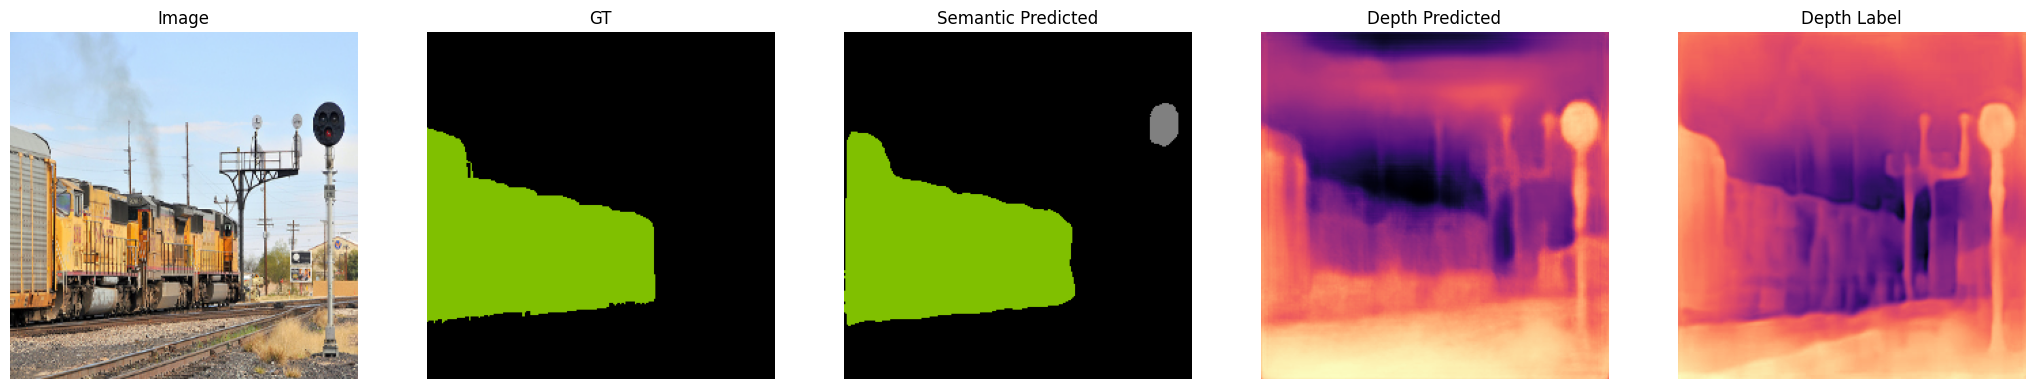

In [22]:
from make_visualize import make_visual

image_num = "2009_000712"
model.load_state_dict(torch.load(f"{dirname}/weights/dnc2.pt"))
make_visual(model, dirname, image_num)

In [13]:
from test_iou import Test_iou

Test_iou(model, test_loader)

accuracy : 0.9705, iou : 0.5359, iIou : 0.0303
